In [23]:
# Download finance data

from datetime import datetime, timedelta

import yfinance as yf

end_date = datetime.today() - timedelta(days=1)
start_date = end_date - timedelta(days=365*10)

df = yf.download('BTC-USD', start=start_date, end=end_date)
df.columns = df.columns.droplevel(1)
df.to_csv('ds/btc_usd.csv')

df.head()

/var/folders/ht/70hjrhkx4j305ctfw65z_43h0000gn/T/ipykernel_19283/3470711737.py:10: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('BTC-USD', start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2015-06-24,240.514999,244.341003,240.514999,244.281998,17344900
2015-06-25,242.798996,243.332001,240.365005,240.365005,16133100
2015-06-26,243.593994,243.748993,241.552994,242.604004,13983500
2015-06-27,250.990005,251.339005,243.117004,243.548996,20488600
2015-06-28,249.011002,251.171997,247.434006,250.955002,15137600


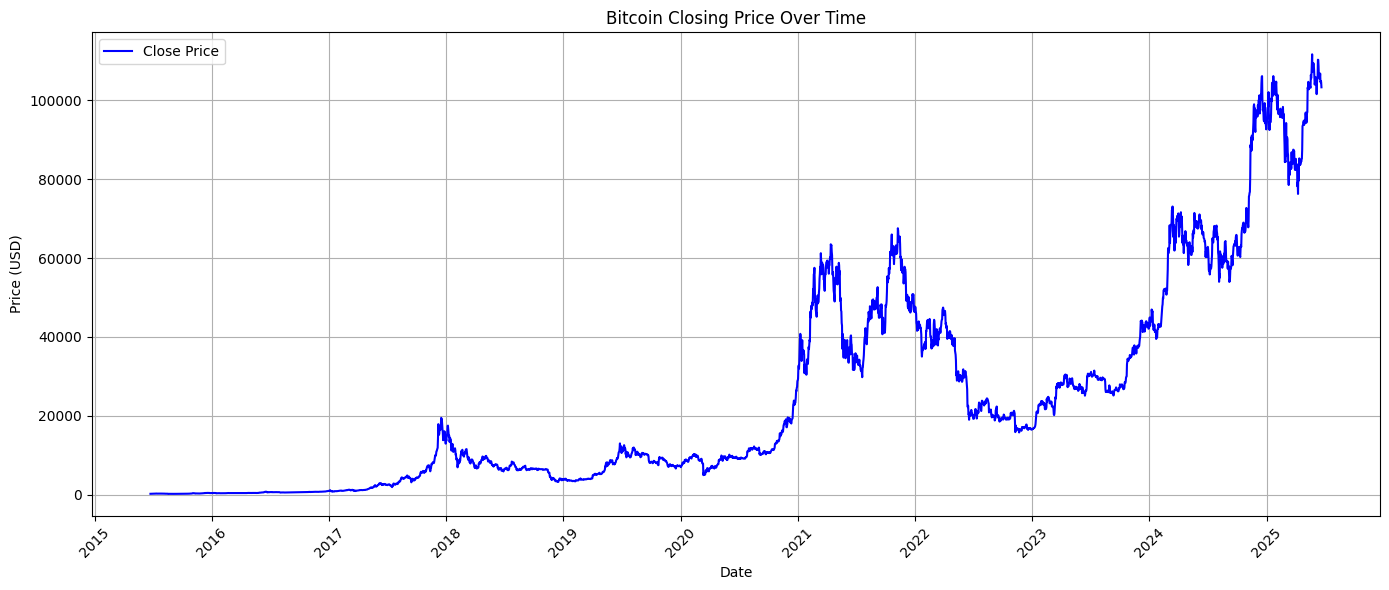

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
data = pd.read_csv('ds/btc_usd.csv')
data['Date'] = pd.to_datetime(data['Date'])

# Plot the closing prices
plt.figure(figsize=(14, 6))
plt.plot(data['Date'], data['Close'], label='Close Price', color='blue')

plt.title('Bitcoin Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

* MinMaxScaler: scale data from specified min to max. Here, normalize (0, 1)

In [18]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Load the adjusted data
data = pd.read_csv('ds/btc_usd.csv')
closing_prices = data[['Close']].values

# Normalize closing prices
scaler = MinMaxScaler(feature_range=(0, 1))
closing_prices_normalized = scaler.fit_transform(closing_prices)

# Prepare data with a window (loop back)
window_size = 120
X_data, y_data = [], []

# Sliding window: every window_size consecutive values are used as input to predict the 121st value (next day forecast)
for i in range(window_size, len(closing_prices_normalized)):
    X_data.append(closing_prices_normalized[i-window_size:i, 0])
    y_data.append(closing_prices_normalized[i, 0])

X_data, y_data = np.array(X_data), np.array(y_data)
X_data = np.reshape(X_data, shape=(X_data.shape[0], X_data.shape[1], 1))  # shape=(sample, window (sample size), 1 feature: Close)

In [19]:
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping

# Split data into training and testing sets
split_ratio = 0.8
train_size = int(len(X_data) * split_ratio)
X_train, X_test = X_data[:train_size], X_data[train_size:]
y_train, y_test = y_data[:train_size], y_data[train_size:]

# Build the LSTM model with dropout for regularization
model = Sequential()
model.add(LSTM(units=32, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.3))
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(units=32))
model.add(Dropout(0.3))
model.add(Dense(units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

# Early stopping to avoid overfitting
# Monitor the validation loss.
# If val_loss doesn’t improve for 5 consecutive epochs, training stops.
# After stopping, it restores the model weights from the epoch with the best val_loss.
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model for 10 full passes over the training data (epochs).
# The model updates its weights after processing each batch of 32 samples (batch_size),
# using the average error (gradient) across those 32 examples to adjust the weights.
# instead of validation_data, is possible to use validation_split
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_data=(X_test, y_test), callbacks=[early_stopping])


/Users/rafagan/Library/Application Support/JetBrains/DataSpell2025.1/projects/workspace/.venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - loss: 0.0102 - val_loss: 0.0023
Epoch 2/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 42ms/step - loss: 0.0015 - val_loss: 0.0188
Epoch 3/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0014 - val_loss: 0.0084
Epoch 4/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 43ms/step - loss: 0.0011 - val_loss: 0.0061
Epoch 5/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0013 - val_loss: 0.0059
Epoch 6/30
89/89 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - loss: 0.0011 - val_loss: 0.0073


In [28]:
# Forecast for the next x days
predict_amount = 6
future_predictions = []
input_data = X_test[-1]  # Last window from test set

for _ in range(predict_amount):  # Forecast for x days
    input_data = input_data.reshape((1, window_size, 1))
    prediction = model.predict(input_data)[0][0]
    future_predictions.append(prediction)
    input_data = np.append(input_data[0, 1:], prediction).reshape(window_size, 1)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


## 📊 Model Evaluation Metrics

To assess the quality of our predictive model, we use several commonly adopted error metrics:

### 🔹 Mean Squared Error (MSE)
$$
\text{MSE} = \frac{1}{n} \sum_{i=1}^{n}(y_i - \hat{y}_i)^2
$$
- Measures the average of the squared differences between actual and predicted values.
- Heavily penalizes larger errors (sensitive to outliers).
- The result is in squared units (e.g., USD²).

### 🔹 Root Mean Squared Error (RMSE)
$$
\text{RMSE} = \sqrt{\text{MSE}}
$$
- Represents the average error in the same units as the data (e.g., USD).
- Easier to interpret than MSE.
- Indicates how much predictions deviate, on average, from real values.

### 🔹 Mean Absolute Error (MAE)
$$
\text{MAE} = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|
$$
- Measures the average magnitude of the errors in a more interpretable way (linear scale).
- Less sensitive to outliers than MSE.
- Expressed in the same unit as the target variable (e.g., USD).

### 🔹 Mean Absolute Percentage Error (MAPE)
$$
\text{MAPE} = \frac{1}{n} \sum_{i=1}^{n} \left| \frac{y_i - \hat{y}_i}{y_i} \right| \times 100
$$
- Expresses the error as a percentage of the actual values.
- Useful when comparing models across datasets with different scales.
- Easy to interpret: e.g., a MAPE of 10% means predictions deviate 10% on average.

### 🧠 Summary

| Metric | Description | Outlier Sensitivity | Unit |
|--------|-------------|----------------------|------|
| **MSE** | Average squared error | High | USD² |
| **RMSE** | Root of MSE, average error | High | USD |
| **MAE** | Average absolute error | Low | USD |
| **MAPE** | Percentage error | Low | % |

Use these metrics together to get a comprehensive understanding of your model's performance.

In [29]:
# Evaluate model quality

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Invert normalization for predictions and real test data
future_predictions_inv = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))
y_train_inv = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))

y_eval = y_test_inv[-predict_amount:]
pred_eval = future_predictions_inv

mse = mean_squared_error(y_eval, pred_eval)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_eval, pred_eval)
mape = np.mean(np.abs((y_eval - pred_eval) / y_eval)) * 100

print(f'MSE: {mse:.2f}')  # in average the error is sqrt(mse) dollars
print(f'RMSE: {rmse:.2f}')  # rmse = sqrt(mse)
print(f'MAE: {mae:.2f}')
print(f'MAPE: {mape:.2f}%')

MSE: 25567145.77
RMSE: 5056.40
MAE: 4981.75
MAPE: 4.74%


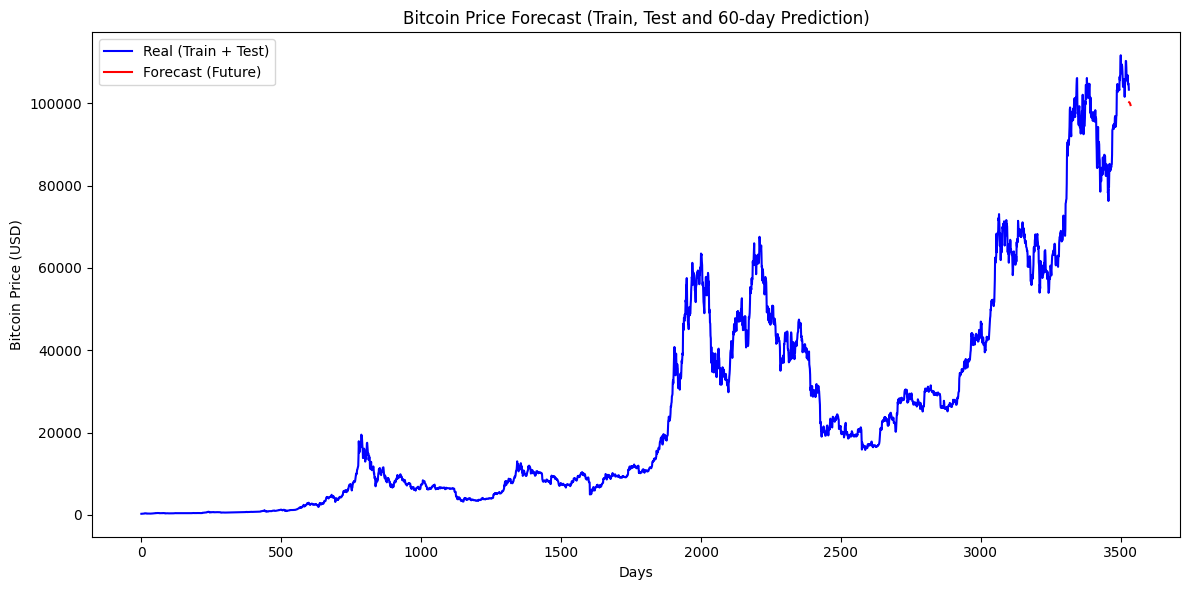

In [30]:
import matplotlib.pyplot as plt

# Concat real prices (train + test)
full_real = np.concatenate([y_train_inv, y_test_inv])

# Prepare full timeline
full_range = np.arange(len(full_real))
forecast_range = np.arange(len(full_real), len(full_real) + len(future_predictions_inv))

plt.figure(figsize=(12, 6))
plt.plot(full_range, full_real, color='blue', label='Real (Train + Test)')
plt.plot(forecast_range, future_predictions_inv, color='red', label='Forecast (Future)')

plt.title(f'Bitcoin Price Forecast (Train, Test and {predict_amount}-day Prediction)')
plt.xlabel('Days')
plt.ylabel('Bitcoin Price (USD)')
plt.legend()
plt.tight_layout()
plt.show()